# TCP Congestion Control and Bufferbloat


In this assignment, you will create your own network simulation to investigate the dynamics of TCP and how seemingly minor configuration decisions made by network operators can have major performance effects. 

As discussed in lecture, TCP is a protocol for obtaining reliable transmission over an unreliable packet-switched network. Another important component of TCP is congestion control, i.e. limiting end host send rates to prevent network infrastructure from getting overwhelmed with traffic. 

However, networks can suffer congestion-related performance issues even when end hosts use TCP. One such issue, known as bufferbloat, can occur when packet buffers on routers and switches are too large. 

In this assignment, you will use Mininet, a useful tool for network experiments, to emulate a small network and collect various performance statistics relevant to TCP congestion control and bufferbloat. This will allow you to reason about the effects of TCP and router configuration on network performance.   

**Put your name and netID in the cell below:**


**Name:**Gulshan Hatzade

**NetId:**CS24MTECH14006

## Background

#### TCP Congestion Window Size
The TCP congestion window size parameter, typically styled "cwnd," is maintained by the sender and determines how much traffic can be outstanding (sent but not acknowledged) at any time. There are many algorithms for controlling the value of cwnd during a TCP connection, all with the goal of maximizing the connection's throughput while preventing congestion. The additive increase and multiplicative decrease algorithm was discussed in lecture.

#### Bufferbloat
Bufferbloat is a phenomenon that happens when a switching device is configured to use excessively large buffers, which can in turn cause high latency and packet delay variation (jitter). This can happen even in a typical home network like the following:
<img width=600 src="figures/home-network.png">
Here, the end host in the home network is connected to the home router. The home router is then connected, via cable or DSL, to a headend router run by the Internet service provider (ISP). By simulating and experimenting with a similar network in Mininet, you will see how bufferbloat causes poor performance.

#### Mininet
Mininet is a network emulator with which you can create a custom network of virtual hosts, switches, controllers, and links, all on a single computer. The virtual devices in the emulated network can run real programs; anything that can run on linux can run on a Mininet device too. This makes Mininet a valuable tool for fast and easy simulation of network protcols and measurements. This [Introduction to Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet) is a useful guide for getting started with Mininet's Python API.  The [Mininet website](http://www.mininet.org) has additional resources if you are interested.

## Part A: Network Simulation & Measurement
To start, you should first create the following network using Mininet's Python API, which emulates a typical home netowrk:
<img width=450 src="figures/mininet-topo.png">
Here h1 is a web server that has a fast connection (1Gb/s) to your home router. The home router has a slow downlink connection (1.5Mb/s) to your home computer. The round-trip propagation delay, or the minimum RTT between h1 and h2 is 20ms.  The router buffer (queue) size will be the parameterized independent variable in your simulation.

To create a custom topology in Mininet, we extend the mininet.topo.Topo class. We have already added the switch (the router) to topology for you. You need to add h1, h2, and links with appropriate characteristics to create the setting specified in the image above.  The first few subsections of the [Working with Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet#working) section of the Mininet guide describe how to add elements to a topology and set performance parameters. 

In [3]:
from mininet.topo import Topo

class BBTopo(Topo):
    "Simple topology for bufferbloat experiment."

    def __init__(self, queue_size):
        super(BBTopo, self).__init__()
        
        # Create switch s0 (the router)
        s0=self.addSwitch('s0')
        
        # TODO: Create two hosts with names 'h1' and 'h2'
        #I added two host h1 and h2 here
        h1 = self.addHost('h1')
        h2 = self.addHost('h2')
        
        # TODO: Add links with appropriate bandwidth, delay, and queue size parameters. 
        #       Set the router queue size using the queue_size argument
        #       Set bandwidths/latencies using the bandwidths and minimum RTT given in the network diagram above
        #
        # Here i am adding the Link from h1 to s0 which has the high bandwidth (1Gb/s) as in above network diagra and low delay
        self.addLink(h1, s0, bw=1000, delay='1ms')
        
        # Here I am adding the Link from s0 to h2 has lower bandwidth (1.5Mb/s) as per above network diagra, 20ms delay, and specified queue size
        self.addLink(s0, h2, bw=1.5, delay='20ms', max_queue_size=queue_size)
        
        return

Next, we need a couple of helper functions to generate traffic between the two hosts. The following function starts a long-lived TCP flow which sends data from h1 to h2 using **iperf**. [Iperf](https://iperf.fr/) is "a tool for active measurements of the maximum achievable bandwidth on IP networks."  You can think of this iperf traffic like a one-way video call. It continually attempts to send a high volume of traffic from the web server h1 to the home computer h2. 

The following function receives one argument called `net`, which is an instance of mininet with a BBTopo topology that we have created above. We have written the part for the iperf server (h2). Notice that in iperf, server is the one that receives data, which should be the home computer h2. You need to complete the function to also start iperf on the iperf client (h1). The iperf session should run for the number of seconds given in the `experiment_time` argument.

You will need to use the `popen` function to run shell commands on a mininet host. The first argument to `popen` is a string command just like you would run in your shell. The second argument should be `shell=True`. You will need to look up the appropriate command line options to run iperf as a client for a given amount of time in the documentation here: [https://iperf.fr/iperf-doc.php#3doc](https://iperf.fr/iperf-doc.php#3doc). You will also need to include the IP address of h2 in your iperf command. This IP address can be accessed with the `h2.IP()` method.  

In [4]:
def start_iperf(net, experiment_time):
    # Start a TCP server on host 'h2' using perf. 
    # The -s parameter specifies server mode
    # The -w 16m parameter ensures that the TCP flow is not receiver window limited (not necessary for client)
    print "Starting iperf server"
    h2 = net.get('h2')
    server = h2.popen("iperf -s -w 16m", shell=True)
    
    # TODO: Start an TCP client on host 'h1' using iperf. 
    #       Ensure that the client runs for experiment_time seconds
    print "Starting iperf client"
    # I am ststing client host h1
    h1 = net.get('h1')
    #I am adding line for initiating the TCP flow from h1 to h2 & running for no. of seconds indiacted by experiment_time
    client_command = "iperf -c {} -t {}".format(h2.IP(), experiment_time)
    client = h1.popen(client_command, shell=True)
    #Returning client & the server
    return server, client


Next, you need to complete the following function that starts a back-to-back ping train from h1 to h2 to measure RTTs. A ping should be sent every 0.1 seconds. Results should be redirected from stdout to the `outfile` argument.

As before, `net` is an instance of mininet with a BBTopo topology. As before, you will need to use `popen`.  The command argument to `popen` can redirect stdout using `>` just like a normal shell command.  Read the man page for `ping` for details on available command line arguments. Make sure the second argument to `popen` is `shell=True`.

In [5]:
def start_ping(net, outfile="pings.txt"):
    # TODO: Start a ping train from h1 to h2 with 0.1 seconds between pings, redirecting stdout to outfile
    print "Starting ping train"
    
    # Here i am Retrieving Mininet host h1 from the network instance net
    h1 = net.get('h1')
    
    # Here I am Retrieving Mininet host h2 from the network instance net
    h2 = net.get('h2')
    
    # This is line for Preparing ping command as a string-
    ping_command = "ping -i 0.1 {} > {}".format(h2.IP(), outfile)
    
    # Here I am Using popen for runningcommand on host h1-
    h1.popen(ping_command, shell=True)


Next, we develop some helper functions to measure the congestion window of the TCP traffic. This will let us analyze at the dynamics of the TCP connections in the mininet network. The following functions are already complete.

In [6]:
from subprocess import Popen
import os

def start_tcpprobe(outfile="cwnd.txt"):
    print("Starting TCP probe. Output: {}".format(outfile))
    os.system("sudo rmmod tcp_probe; sudo modprobe tcp_probe")
    process = Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)
    
def stop_tcpprobe():
    Popen("killall -9 cat", shell=True).wait()

We then create a helper function that monitors the queue length on a given interface. This will let us analyze how the number of packets in router buffer queues affects performance. This function is already complete.

In [7]:
from multiprocessing import Process
from monitor import monitor_qlen

def start_qmon(iface, interval_sec=0.1, outfile="q.txt"):
    monitor = Process(target=monitor_qlen,
                      args=(iface, interval_sec, outfile))
    monitor.start()
    return monitor

We also need a helper function that starts a webserver on h1. This function is already complete.

In [8]:
from time import sleep

def start_webserver(net):
    h1 = net.get('h1')
    proc = h1.popen("python http/webserver.py", shell=True)
    sleep(1)
    return [proc]

Finally, we need a helper function that runs on h2, fetches the website from h1 every 3 seconds for `experiment_time`, and prints the average and standard deviation of the download times. This function is already complete

In [9]:
from time import time
from numpy import mean, std
from time import sleep

def fetch_webserver(net, experiment_time):
    h2 = net.get('h2')
    h1 = net.get('h1')
    download_times = []
    
    start_time = time()
    while True:
        sleep(3)
        now = time()
        if now - start_time > experiment_time:
            break
        fetch = h2.popen("curl -o /dev/null -s -w %{time_total} ", h1.IP(), shell=True)
        download_time, _ = fetch.communicate()
        print "Download time: {0}, {1:.1f}s left...".format(download_time, experiment_time - (now-start_time))
        download_times.append(float(download_time))
        
    average_time = mean(download_times)
    std_time = std(download_times)
    print "\nDownload Times: {}s average, {}s stddev\n".format(average_time, std_time)

Now, we need to put together all the pieces to create the network, start all the traffic, and make the measurements. 

The following `bufferbloat()` function should:
* create a `BBTopo` object
* start the TCP and queue monitors
* start a long-lived TCP flow using iperf
* start the ping train
* start the webserver
* Periodically download the index.html web page from h1 and measure how long it takes to fetch it 

Note that the long lived flow, ping train, and webserver downloads should all be happening simultaneously. Once you have completed the assignment steps up until here, complete the sections marked `TODO` in the below `bufferbloat()` function. Each TODO section requires adding one line to call a function defined above.

In [10]:
from mininet.node import CPULimitedHost, OVSController
from mininet.link import TCLink
from mininet.net import Mininet
from mininet.log import lg, info
from mininet.util import dumpNodeConnections

from time import time
import os
from subprocess import call

def bufferbloat(queue_size, experiment_time, experiment_name):
    # Don't forget to use the arguments!
    
    # Set the cwnd control algorithm to "reno" (half cwnd on 3 duplicate acks)
    #    Modern Linux uses CUBIC-TCP by default that doesn't have the usual sawtooth
    #    behaviour.  For those who are curious, replace reno with cubic
    #    see what happens...
    os.system("sysctl -w net.ipv4.tcp_congestion_control=reno")
    
    # create the topology and network
    topo = BBTopo(queue_size)
    net = Mininet(topo=topo, host=CPULimitedHost, link=TCLink, 
                  controller= OVSController)
    net.start()

    # Print the network topology 
    dumpNodeConnections(net.hosts)
    
    # Performs a basic all pairs ping test to ensure the network set up properly
    net.pingAll()
    
    # Start monitoring TCP cwnd size
    outfile = "{}_cwnd.txt".format(experiment_name)
    start_tcpprobe(outfile)

    # TODO: Start monitoring the queue sizes with the start_qmon() function.
    #       Fill in the iface argument with "s0-eth2" if the link from s0 to h2
    #       is added second in BBTopo or "s0-eth1" if the link from s0 to h2
    #       is added first in BBTopo. This is because we want to measure the 
    #       number of packets in the outgoing queue from s0 to h2. 
    outfile = "{}_qsize.txt".format(experiment_name)
    qmon = start_qmon(iface="s0-eth2", outfile=outfile)

    # TODO: Start the long lived TCP connections with the start_iperf() function
    #Here I am starting long lived TCP connection
    start_iperf(net, experiment_time)
    
    # TODO: Start pings with the start_ping() function
    outfile = "{}_pings.txt".format(experiment_name)
    # I am adding function as per to do requirements
    start_ping(net, outfile)

    
    # TODO: Start the webserver with the start_webserver() function
    # Here I am Starting web server
    start_webserver(net)

    
    # TODO: Measure and print website download times with the fetch_webserver() function
    # Here I added code line for Measuring & printing website download times
    fetch_webserver(net, experiment_time)
    
    # Stop probing 
    stop_tcpprobe()
    qmon.terminate()
    net.stop()
    
    # Ensure that all processes you create within Mininet are killed.
    Popen("pgrep -f webserver.py | xargs kill -9", shell=True).wait()
    call(["mn", "-c"])

Once you have completed all the steps above, use the `bufferbloat()` function to run the experiment twice, once with queue size of a 20 packets and then queue size of 100 packets. Make sure to run the experiments long enough to see the dynamics of TCP, like the sawtooth behavior of cwnd, in your results (300 seconds should be good).  Choose `experiment_name` arguments that reflect the queue size

In [11]:
from subprocess import call
call(["mn", "-c"])

# TODO: call the bufferbloat function twice, once with queue size of 20 packets and once with a queue size of 100.
# Here I am Runnig bufferbloat function twice with different queue sizes as mentioned in my task
bufferbloat(queue_size=20, experiment_time=300, experiment_name="experiment_queue_20")
bufferbloat(queue_size=100, experiment_time=300, experiment_name="experiment_queue_100")


h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting TCP probe. Output: experiment_queue_20_cwnd.txt
Starting iperf server
Starting iperf client
Starting ping train
Download time: 0.471, 297.0s left...
Download time: 1.640, 293.4s left...
Download time: 1.305, 288.7s left...
Download time: 1.509, 284.4s left...
Download time: 1.540, 279.8s left...
Download time: 1.628, 275.2s left...
Download time: 0.440, 270.6s left...
Download time: 1.819, 267.1s left...
Download time: 0.276, 262.2s left...
Download time: 0.445, 258.9s left...
Download time: 1.416, 255.4s left...
Download time: 1.241, 251.0s left...
Download time: 2.727, 246.7s left...
Download time: 1.529, 240.9s left...
Download time: 1.585, 236.4s left...
Download time: 1.528, 231.7s left...
Download time: 1.856, 227.2s left...
Download time: 1.296, 222.3s left...
Download time: 0.504, 217.9s left...
Download time: 0.430, 214.4s left...
Download time: 1.815, 210.9s left...
Download time: 1.680, 206.1s left...
Download time: 0.466, 201.4s left...
Download time: 1.482, 197.9s

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting TCP probe. Output: experiment_queue_100_cwnd.txt
Starting iperf server
Starting iperf client
Starting ping train
Download time: 5.166, 297.0s left...
Download time: 1.582, 288.7s left...
Download time: 1.689, 284.1s left...
Download time: 1.676, 279.4s left...
Download time: 1.784, 274.7s left...
Download time: 1.777, 269.9s left...
Download time: 1.827, 265.0s left...
Download time: 1.903, 260.2s left...
Download time: 1.923, 255.2s left...
Download time: 1.955, 250.3s left...
Download time: 2.031, 245.3s left...
Download time: 2.054, 240.2s left...
Download time: 2.071, 235.1s left...
Download time: 2.121, 230.0s left...
Download time: 2.185, 224.8s left...
Download time: 2.218, 219.6s left...
Download time: 2.273, 214.4s left...
Download time: 2.258, 209.0s left...
Download time: 2.323, 203.7s left...
Download time: 2.376, 198.4s left...
Download time: 2.451, 193.0s left...
Download time: 2.472, 187.5s left...
Download time: 2.478, 182.0s left...
Download time: 2.509, 176.4

## Part B: Plotting Results

In this part of the assignment, you will analyze your measurements by plotting the variations in congestion window, queue length, and ping RTT versus time. We have provided plotting functions for each of these measurements, which are called in the following already complete `plot_measurements()` function. 


In [12]:
%matplotlib inline
from plot_cwnd import plot_congestion_window
from plot_qsize import plot_queue_length
from plot_ping import plot_ping_rtt

def plot_measurements(experiment_name_list, cwnd_histogram=False):
    
    # plot the congestion window over time
    for name in experiment_name_list:
        cwnd_file = "{}_cwnd.txt".format(name)
        plot_congestion_window(cwnd_file, histogram=cwnd_histogram)
    
    # plot the queue size over time
    for name in experiment_name_list:
        qsize_file = "{}_qsize.txt".format(name)
        plot_queue_length(qsize_file)
    
    # plot the ping RTT over time
    for name in experiment_name_list:
        ping_file = "{}_pings.txt".format(name)
        plot_ping_rtt(ping_file)

Now you need to call the `plot_measurements` function such that the `experiment_name_list` argument is list of the `experiment_name` arguments you used to run `bufferbloat()` above.  This should generate 6 plots with the results of the experiments.

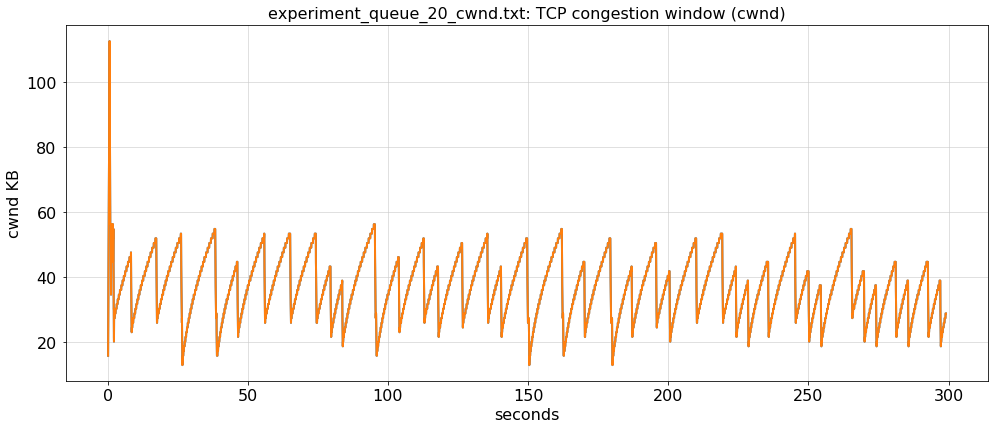

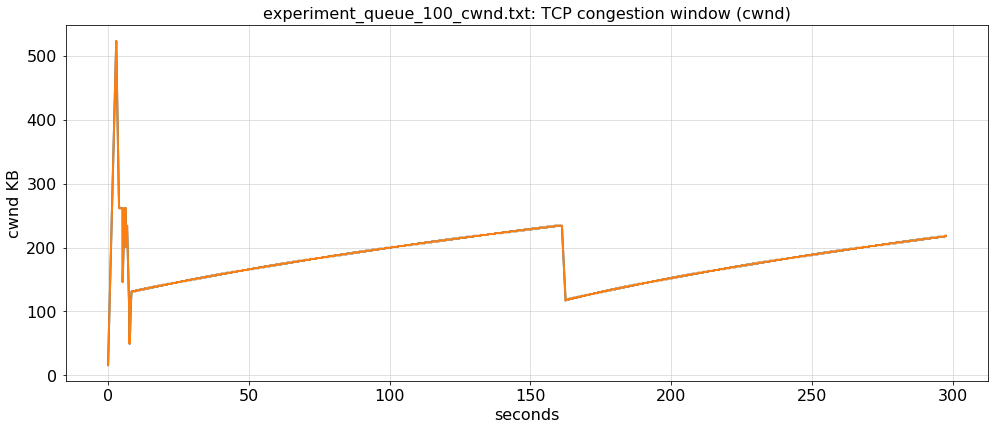

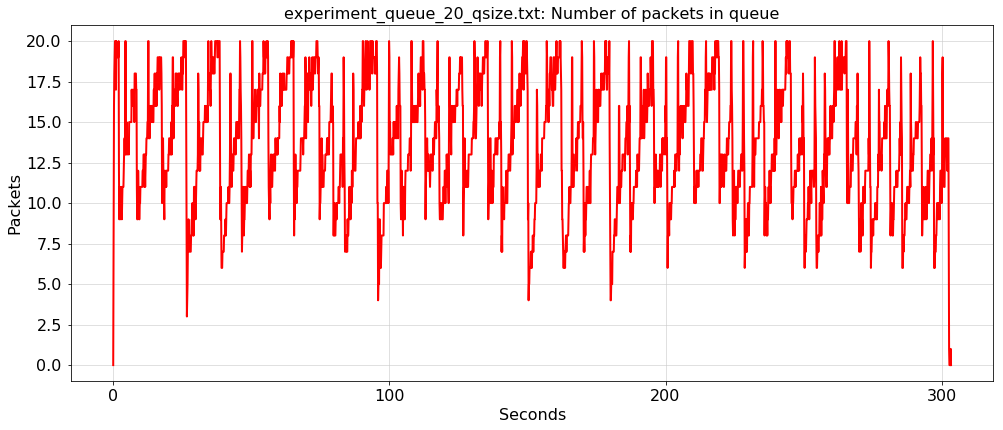

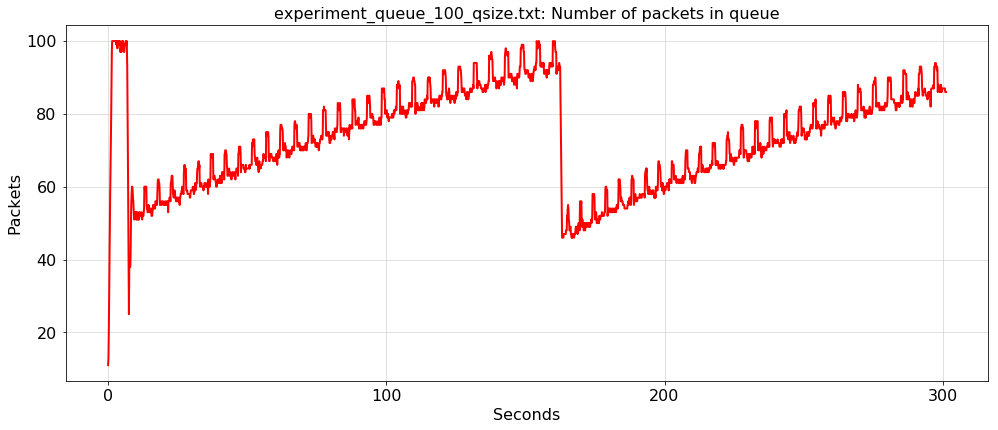

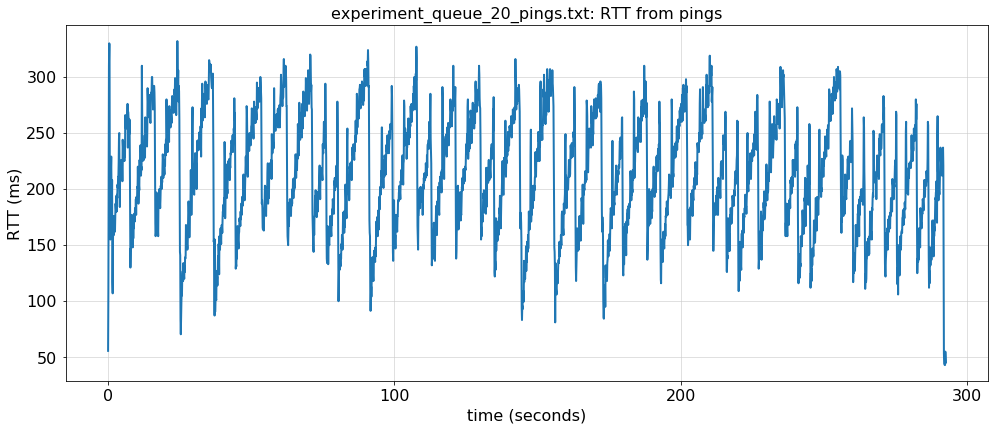

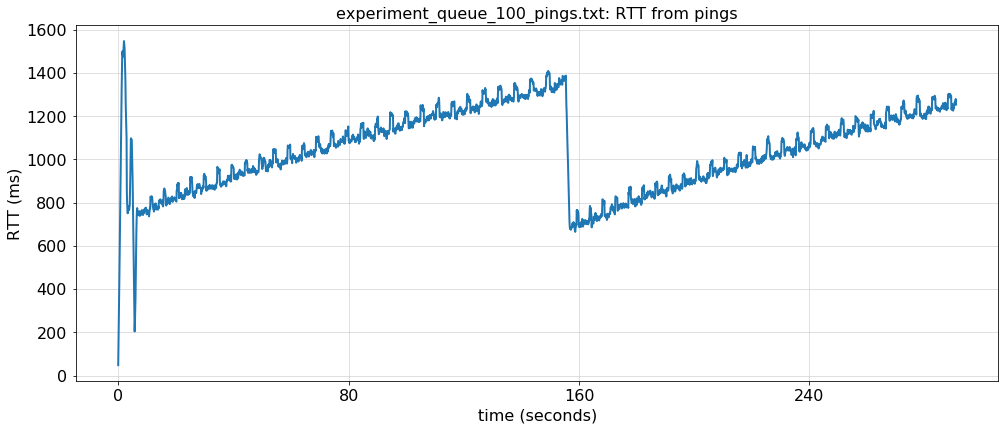

In [13]:
#TODO: Call plot_measurements() to plot your results
# Here I am using List of experiment names used in the bufferbloat() function
experiment_names = ["experiment_queue_20", "experiment_queue_100"]

# Now I am calling plot_measurements function for plotting results for both experiments
plot_measurements(experiment_names)



## Part C: Analysis

In this part of the assignment, you will answer some questions about TCP and bufferbloat using your simulations and the plots from the previous section.  This questions are intentionally open-ended and many have multiple correct answers.  There is no required answer length, but attempt to be both thorough and concise.  1-2 sentences is probably too short. More than 2-3 paragraphs is probably too long. 

Take some time first to think about the simulation you just performed. The simulation was set up like a home network with a home computer connected to a remote server through a router. The link from the router to the server had much lower bandwidth than the link from the home computer to the router. The independent variable in the simulation was the maximum length of the buffer of packets waiting to be sent from the router to the server. 

There were 3 sources of traffic:
1. A long-lasting TCP session (creating using iperf) sending a high volume of traffic from the home computer to the server.
2. Regularly spaced pings and ping replies to and from the home computer and the server
3. Regularly spaced attempts to download a website (using HTTP over TCP) from the home computer to the server.

As you (hopefully) discovered through the experiment, increasing the length of the packet buffer on the router significantly reduced performance by both ping RTT and HTTP download rate metrics. 

### Questions

#### Q1.
What computer networks other than a home network might have a configuration like the one you simulated?

#### A1.
The network with characteristics same as that of which I simulated home network is the cellular network where end devices like phone onnect through the cell tower, which then connects to broader internet. In such networks, link between the device & tower often has higher bandwidth & lower delay compared to the link between cell tower & core internet infrastructure. Other example for same is satellite based rural networks, here home devices connect through the local satellite router, & then data is sent through satellite link where satellite connection has potentially higher latency& limited bandwidth. We can relate this networks to the network which I stimulated in this assignment.

#### Q2.
Write a symbolic equation to describe the relation between RTT and queue size. 

The symbolic equation should be generalized to any queue size. Basically, consider a snapshot of a system at one point of time, and use queue size and link delays parametrically to compute the RTT

An example (incorrect) symbolic equation: 
$$RTT = kq^2$$
where $k$ is a constant factor and $q$ is the number of packets in the queue. Your equation is not limited to $k$ and $q$. 

#### A2.
We can write Round trip time as follows,

$$
\text{RTT} = 2 \times (L_{\text{link}} + D_{\text{proc}} \cdot q) + \frac{q*S}{R}
$$



 where
 - q is the number of packets in the queue
 - L_link is the propogation delay on the link
 - D_proc is the processing delay of packet
 - R is badwidth of link
 - S is packet size
       
     
The above formula is capturing adds round trip time to queing delay, which will increaseas packets added to buffer & time it is taking for transmitting queued packets given the bandwidth of link.


Just taking instance for experiment of queue size of 100 at packets  q=60,
considering propogation delay on link of 10ms, processing delay of 4ms per packet and packet size s=12000 bits, with R=1.5 * 10^6 bps

RTT = 2(10 +4*60) ms   +  (60*12000)/(1500000) seconds
    = 500ms  +  0.48 seconds
    = 980 ms
This obtained value of RTT correctly fits with my graph obtained.

#### Q3.  
Describe in technical terms why increasing buffer size reduces performance (RTTs and webpage download times), causing the bufferbloat effect.  Be sure to explicitly reference the plots you generated and the relationship between TCP congestion control and buffer size. *This is the most important question and will be weighted correspondingly more.*

#### A3.
By observing my graphs, effects of buffer size on RTT & download times in my experiments are the direct result of bufferbloat. Here larger buffers in router is introducing the significant latency. In my assignment, for queue size of 20 packet, the round trip time & packet graphs showed the frequent & rapid oscillations with small variations. This behavior I oberved showed that queue was reaching capacity frequently but is quickly draining which is preventing prolonged delays. In congestion window -cwnd graph for the queue size of 20, congestion control algorithm  of TCP responded to this quick fluctuation which is leading to characteristic "sawtooth" pattern, as sender detected packet loss quickly & immediate action is taken resulting in adjusted window size.

Now,lets analyse for packet queue size of 100, graphs show the different behavior. RTT graph indicates much higher delay (increased from 800 ms to 1400 ms) as queue gradually fills up over time which is stabilizing as packets are dropped. This observed slower, longer increase in the RTT & buffer length suggests build-up of packets in buffer which is causing delayed acknowledgments & also extended RTTs. The time when queue eventually empties then RTT and buffer size drop suddenly. This pattern is also visible in cwnd graph where larger buffer sizes are allowing congestion window to grow significantly before hitting network limits which is causing sudden reductions once the threshold is reached.

So, on increasing buffer size from 20 to 100 packets worsens latency, as shown by higher RTTs & slower TCP adjustments. While larger buffers are allowing more traffic but they are creating delays due to packet buildup, slowing TCP’s response to congestion & degrading performance. This demonstrates that how excessive buffering can harm, rather than helping network efficiency specially for latency sensitive applications.



#### Q4. 
Re-describe the cause of the bufferbloat effect using a non-technical analogy to something other than computer networking.  It is important to be able to describe technical content such that a layperson can understand, and generating analogies often helps your own reasoning. 

#### A4.
We can imagine single cashier in busy supermarket with 2 potential line management strategies. For the smaller queue (like queue size 20 in our case), only the few customers are allowed to queue which is causing quick movement of line, & cashier processes each customer without much delay. Here also some people may have to wait outside if line fills up but here each customer in line is processed efficiently.

On the other hand, the larger queue (like queue size 100 in our case) is allowing many more customers to line up inside. At the begining this seems advantageous since more people are in line. But as more people queue up, each new customer have to suffer from longer waiting for their turn,& line length itself causes congestion. When cashier is finally able to serve everyone in line, there is sudden emptying, but soon customers start piling up again which is creating waves of congestion similar to what was observed in my experiment graph with bufferbloat.

#### Q5. 
Is the bufferbloat effect specific to the type of network, traffic, and/or TCP congestion control algorithm we simulated, or is it a general phenomenon?

Are there any times when increasing router buffer size would improve performance? If so, give an example.  If not, explain why not. 

#### A5.
Bufferbloat is the general phenomenon & it can occur in any network where there is not balacing of buffering with throughput & the latency requirements. It is seen in WiFi networks, cellular networks & also ineven data center environments if buffers are too large relative to capacity of link.

Increasing buffer size can results in improving the performance in networks with burst traffic where short & high volume data transfers occur. For example we can consider video streaming applications which are having the larger buffer which helps in absorbing sudden bursts of data which is reducing interruptions during playback. But his advantage only holds if bursts are only short lived and do not continuously fill our buffer, as sustained high traffic may results in same delay problems observed in bufferbloat.

#### Q6.
Identify and describe a way to mitigate the bufferbloat problem without reducing buffer sizes.  

#### A6.
One of the effective way of mitigating bufferbloat without reducing buffer size is implementing AQM (Active Queue Management) algorithms like CoDel (Controlled Delay) algorithm or RED (Random Early Detection) algorith. By monitoring queue latency & actively managing packet dropping rates before buffer becomes fully saturated, these algorithms perform better. By proactively dropping or marking packets, AQM techniques helps keeping buffer occupancy low & also maintaining lower latency while still allowing buffer for handling transient bursts in traffic.

#### ANTI-PLAGIARISM Statement

I certify that this assignment/report is the result of my own independent work, based on my personal study and research. All sources, including books, articles, software, datasets, reports, and communications, have been properly acknowledged. This work has not been previously submitted for assessment in any other course unless specific permission was granted by the respective instructors.
I also acknowledge the use of AI tools, such as LLMs (e.g., ChatGPT), for assistance in refining this assignment, if used. I have ensured that their usage complies with the academic integrity policies of this course.
I pledge to uphold the principles of honesty, integrity, and responsibility at CSE@IITH, and understand my duty to report any violations of academic integrity by others if I become aware of them.
Name: <Your Name>
Roll No: <Your Roll Number>
Date: <Date>
Signature: <Your Initials>


## Submission 

**Remember to "Save and Checkpoint" (from the "File" menu above) before you leave the notebook or close your tab.**
